# Project 2: Moneyball

<i>
Submission by Diana Chou <br>
CMSC320: Introduction to Data Science <br>
Due: October 16, 2019
</i>

<p>For this project, we will be analyzing data about teams in Major League Baseball in order to understand how efficient teams have been historically at spending money and getting wins in return.</p>
<p>In the case of <u>Moneyball</u>, one would expect that Oakland was not much more efficient than other teams in their spending before 2000, were much more efficient (they made a movie about it after all) between 2000 and 2005, and by then other teams may have caught up. Our goal is to see how this is reflected in the data we have.</p>

## Part 1: Wrangling

<p>Using SQL, we can compute a relation containing the total payroll and winning percentage. We start by first establishing a connection to the database.</p>

In [1]:
# Connect to the database
import sqlite3
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

<p>Now, let's take a look at the query results from each individual table for comparison, specifically the salaries and winning percentages (wins-to-games ratio) for each team and year combination.</p>

#### All recorded salaries grouped by yearID and teamID

In [2]:
# Select the year, team, and total salary from the Salaries table
# (ordered in increasing order by year and then lexigraphically by team)
salary_query = "SELECT yearID, teamID, sum(salary) as totalPayroll \
FROM Salaries GROUP BY yearID, teamID"
salaries = pd.read_sql(salary_query, conn)
print("Total Payroll Queries: " + str(len(salaries)) + " records")

salaries.head() # view the earliest 5 records

Total Payroll Queries: 860 records


,yearID,teamID,totalPayroll
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0


#### All recorded winning percentages grouped by yearID and teamID

In [3]:
# Select the year, team, franchise, wins, games, and calculated winning percentage from the Teams table
# (ordered in increasing order by year and then lexigraphically by team)
win_query = "SELECT yearID, teamID, franchID, W, G, (W*1.0/G*1.0)*100 as winningPercentage \
FROM Teams GROUP BY yearID, teamID"
wins = pd.read_sql(win_query, conn)
print("Winning Percentage Queries: " + str(len(wins)) + " records")

wins.head() # view the earliest 5 records

Winning Percentage Queries: 2775 records


,yearID,teamID,franchID,W,G,winningPercentage
0,1871,BS1,BNA,20,31,64.516129
1,1871,CH1,CNA,19,28,67.857143
2,1871,CL1,CFC,10,29,34.482759
3,1871,FW1,KEK,7,19,36.842105
4,1871,NY2,NNA,16,33,48.484848


### Problem 1:

<p>We can see right away that there are far more query records of winning percentages (2775 entries) than there are of total payrolls (860). In fact, one noticable difference is that the first record of salaries start in the year 1985, whereas the first record of wins-to-games dates all the way back to 1871 – that's a 114 year gap!</p>
<p>Instead, let's try adjusting our query so that we only view winning games starting from 1985.</p>

#### All recorded winning percentages grouped by yearID and teamID starting from 1985 

In [4]:
wins_from1985 = "SELECT yearID, teamID, franchID, W, G, (W*1.0/G*1.0)*100 as winningPercentage \
FROM Teams WHERE yearID >= 1985 GROUP BY yearID, teamID"
wins2 = pd.read_sql(wins_from1985, conn)

wins2.head()# view the earliest 5 records

,yearID,teamID,franchID,W,G,winningPercentage
0,1985,ATL,ATL,66,162,40.740741
1,1985,BAL,BAL,83,161,51.552795
2,1985,BOS,BOS,81,163,49.693252
3,1985,CAL,ANA,90,162,55.555556
4,1985,CHA,CHW,85,163,52.147239


In [5]:
print("Total Payroll Queries: " + str(len(salaries)) + " records")
print("Winning Percentage Queries: " + str(len(wins)) + " records")
print("Winning Percentage Queries from 1985: " + str(len(wins2)) + " records")

Total Payroll Queries: 860 records
Winning Percentage Queries: 2775 records
Winning Percentage Queries from 1985: 858 records


<p> After using the 'WHERE' clause to filter records where 'yearID >= 1985', we get 858 results. From this, we can now see that there is indeed a huge chunk of missing data in the Salaries table. Since the salaries query gave 860 records, we can also see that there are 2 entries missing from the Teams table that exist in the Salaries table. A majority of the difference lied in the lack of salary records between the years 1871 and 1984.</p>
<p>In order to create a reliable relationship between the two tables, we need to construct a new query indicating that any combination of yearID and teamID have <b>both</b> an <i>existing total payroll</i> and an <i>existing winning percentage</i>.</p>

In [6]:
# Create the query using an INNER JOIN 
query = "SELECT t.yearID, t.teamID, t.franchID, t.W, t.G, \
(t.W*1.0/t.G*1.0)*100 as winningPercentage, sum(s.salary) as totalPayroll \
FROM Salaries as s \
INNER JOIN Teams as t \
ON s.yearID = t.yearID AND s.teamID = t.teamID \
GROUP BY s.yearID, s.teamID"

df = pd.read_sql(query, conn)
df.head() # view first 5 records of df after INNER JOIN

,yearID,teamID,franchID,W,G,winningPercentage,totalPayroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0


<p>This can be done by using the 'INNER JOIN' SQL clause between the Salaries and Team tables. An inner join between two tables selects records that have matching values in <b>both tables</b> based on the join predicate. Thus, by using: <pre>'INNER JOIN...ON s.yearID = t.yearID AND s.teamID = t.teamID'</pre> We can compare the data for each year and team combination that have existing records of both a winning percentage as well as a total payroll.
</p>

## Part 2: Exploratory Data Analysis

### Problem 2: 

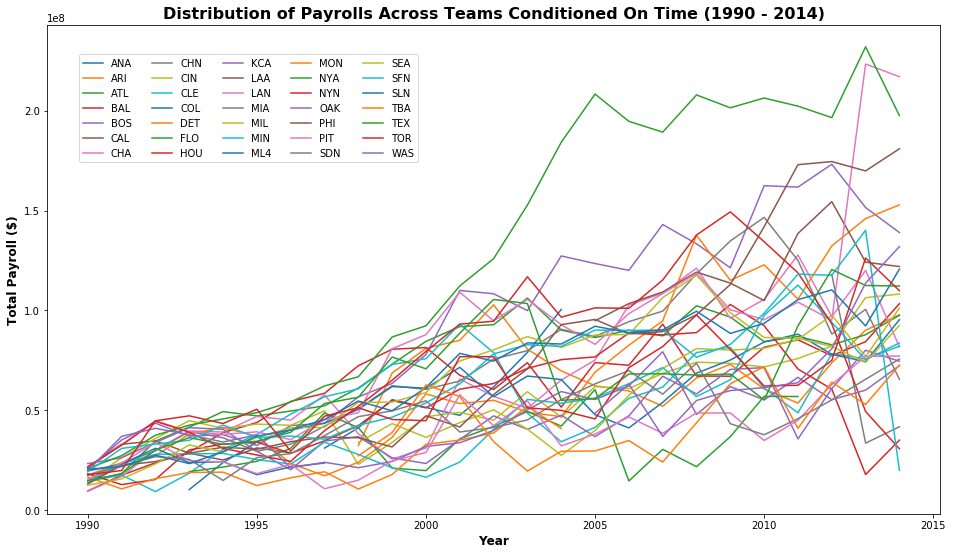

In [7]:
query = "SELECT t.yearID, t.teamID, t.franchID, t.W, t.G, \
(t.W*1.0/t.G*1.0)*100 as winningPercentage, sum(s.salary) as totalPayroll \
FROM Salaries as s INNER JOIN Teams as t \
ON s.yearID = t.yearID AND s.teamID = t.teamID \
WHERE s.yearID >= 1990 AND s.yearID <= 2014 GROUP BY s.yearID, s.teamID"

df = pd.read_sql(query, conn)
salaries = df.pivot(index='yearID', columns='teamID', values='totalPayroll')
plt.rcParams["figure.figsize"] = [16,9]

for col in (salaries.columns):
    plt.plot(salaries[col], label=col)
    plt.legend(col)

yMax = plt.ylim()[1]
plt.title("Distribution of Payrolls Across Teams Conditioned On Time (1990 - 2014)", size=16, weight='bold')
plt.xlabel("Year", size=12, weight='bold')
plt.ylabel("Total Payroll ($)", size=12, weight='bold')
plt.legend(bbox_to_anchor=(0.03,0.95), loc=2, ncol=5)
plt.show()

In [8]:
min1990 = df.loc[df['yearID'] == 1990].sort_values('totalPayroll').head(1)['totalPayroll'].values[0]
max1990 = df.loc[df['yearID'] == 1990].sort_values('totalPayroll').tail(1)['totalPayroll'].values[0]
min2014 = df.loc[df['yearID'] == 2014].sort_values('totalPayroll').head(1)['totalPayroll'].values[0]
max2014 = df.loc[df['yearID'] == 2014].sort_values('totalPayroll').tail(1)['totalPayroll'].values[0]

print("Lowest salary in 1990: $" + str(min1990))
print("Highest salary in 1990: $" + str(max1990))
print("... which is a difference of: $" + str(max1990-min1990))
print("\nLowest salary in 2014: $" + str(min2014))
print("Highest salary in 2014: $" + str(max2014))
print("... which is a difference of: $" + str(max2014-min2014))

Lowest salary in 1990: $9491500.0
Highest salary in 1990: $23361084.0
... which is a difference of: $13869584.0

Lowest salary in 2014: $20000000.0
Highest salary in 2014: $217014600.0
... which is a difference of: $197014600.0


### Question 1

<i><b>What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.</b></i>
<br>

<p>The plot diagram above shows every team's yearly payroll over the course of years 1990 to 2014. With the data plotted, we can now make some observations by looking at the graph.</p>

<p>Starting in the 1990s, all teams were all earning relatively low yearly salaries, with the lowest total payroll being \$9,491,500 and highest, \$23,361,084 (the difference in total payroll comes to \$13,869,584). By 2014, the lowest payroll distributed was \$20,000,000, whereas the highest was recorded at \$217,014,600 (that's a difference of \$197,014,600, which is almost 200k!)</p>

<p>Also, even though some teams had salaries that fluctuated in different years (their salaries would go up and down), most teams generally seemed to have an overall increase in salary.</p>

<p>From this we see that over time, the distribution in payroll became wider and average salary grew at a low rate, indicating an <b>increase in spread and central tendency</b>.</p>

### Problem 3

<p>One way we can analyze the data is by looking at a measure of central tendency, and more specifically, the <i>arithmetic mean</i> or <i>average</i>. The mean is calculated by dividing the sum of all the data values by the total number of data occurences. In relation to our dataset, we divide the total payroll distributed by the number of teams for each year and plot the results as a line of central tendency in the figure below.</p>

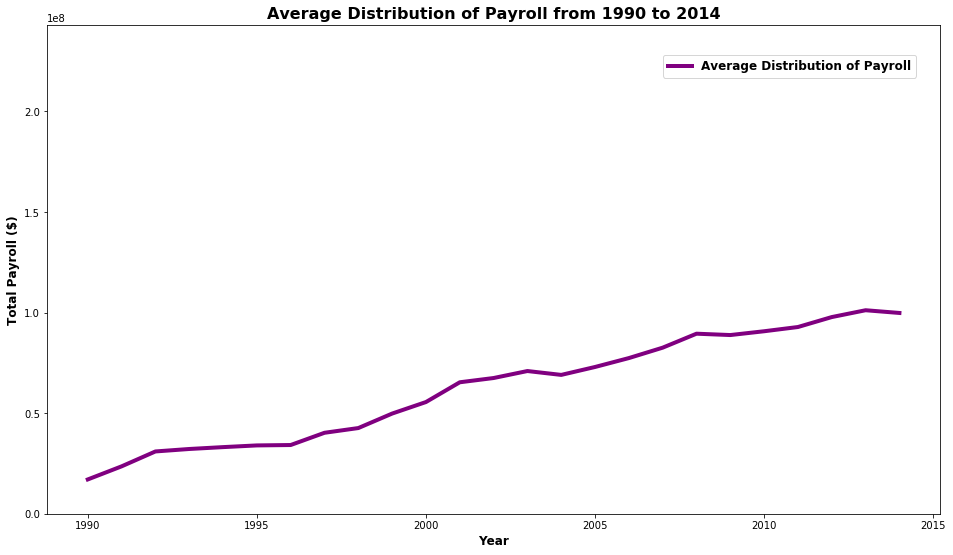

In [9]:
average = salaries.mean(axis=1)
plt.rcParams["figure.figsize"] = [16,9]
plt.ylim(0,yMax)
plt.plot(average, label="Average Distribution of Payroll", c='purple', lw=4)
plt.title("Average Distribution of Payroll from 1990 to 2014", size=16, weight='bold')
plt.xlabel("Year", size=12, weight='bold')
plt.ylabel("Total Payroll ($)", size=12, weight='bold')
plt.legend(bbox_to_anchor=(.98,.95), loc=1, prop={'size': 12, 'weight':'bold'})
plt.show()

<p>This newly constructed data plot shows the line of central tendency (mean) of total payroll distributed per year from 1990 to 2014. As shown, the plot accurately reflects our statement about the increase in central tendency.</p>

### Problem 4

<p>Now we need to find the correlation between payroll and winning percentages in the data.</p> 
<p>We can do this by separating the years (1990 - 2014) into five consecutive time periods (each consisting of 5 years). Within each time period, we display each team's average payroll and average winning percent relation as a scatterplot, and add a regression line to help interpret our results.</p>

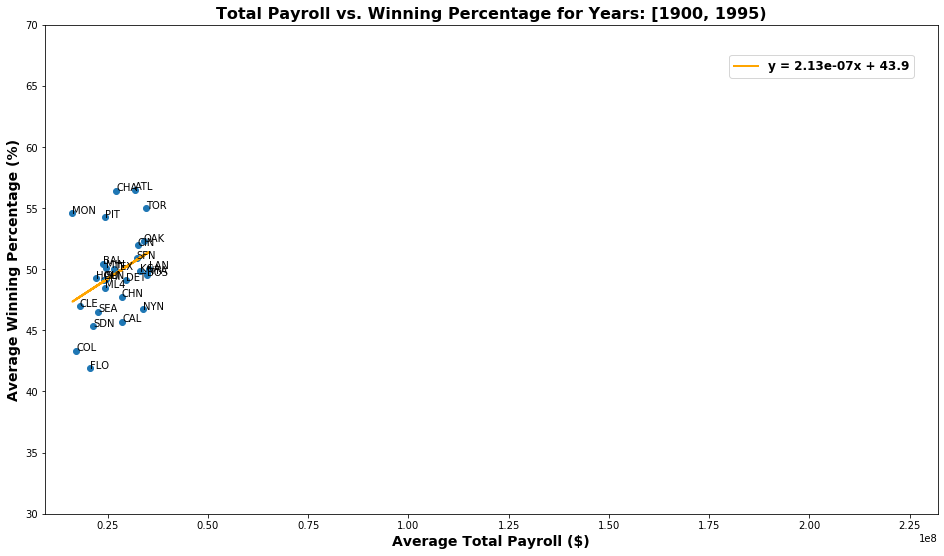

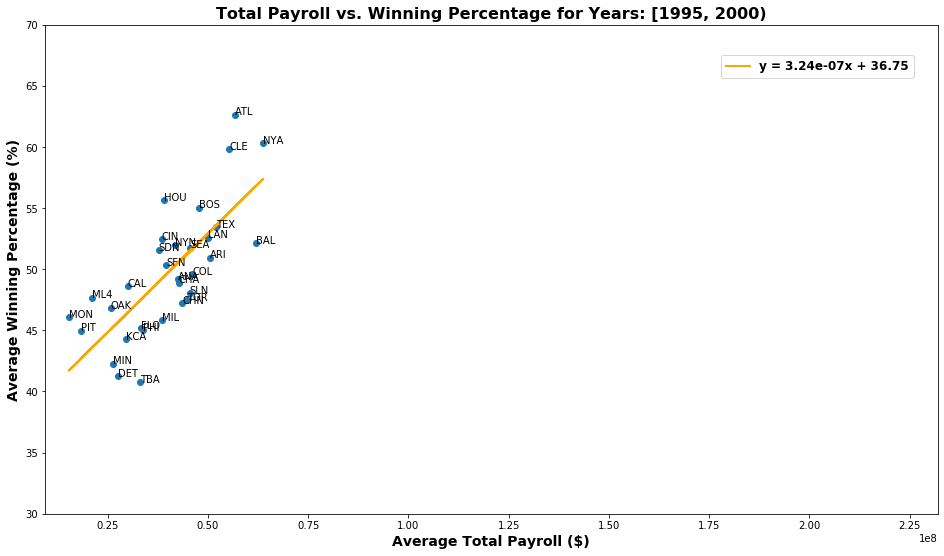

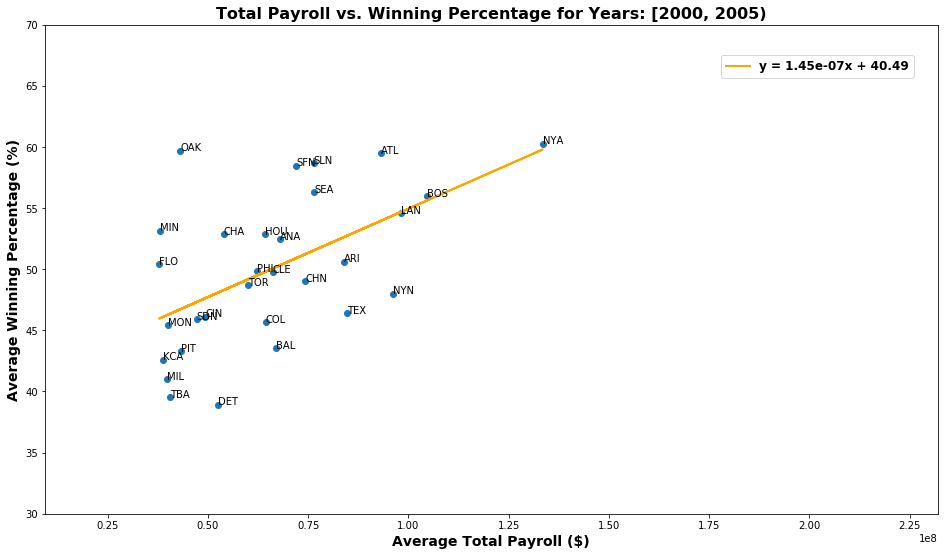

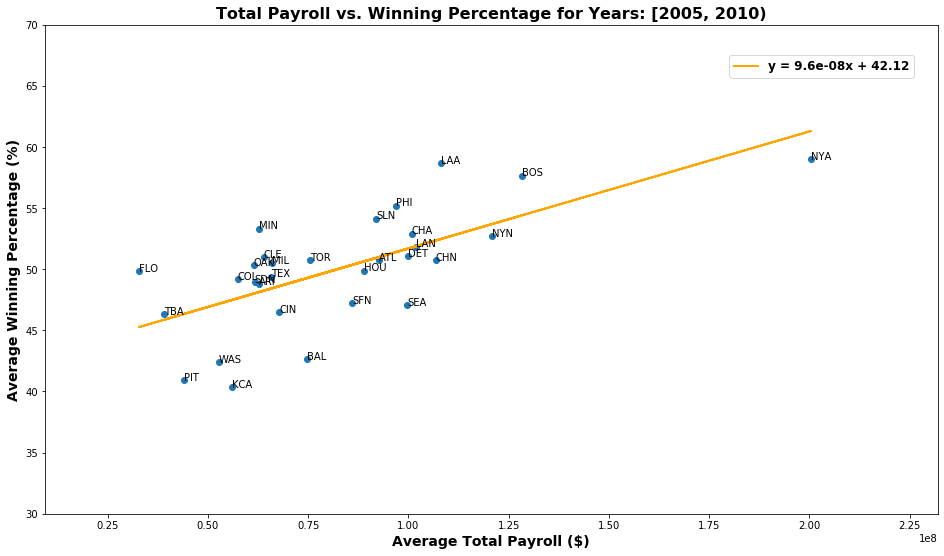

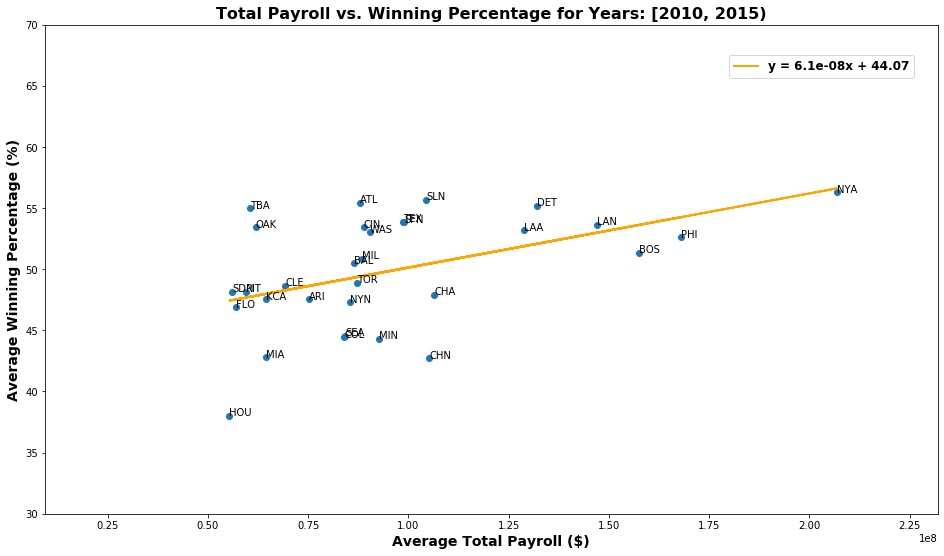

In [10]:
# Discretize year into five time periods
bins = [1900, 1995, 2000, 2005, 2010, 2015]
df['binned'] = pd.cut(df['yearID'], bins, right=False)
xMin = df['totalPayroll'].min()
xMax = df['totalPayroll'].max()

# Create scatterplot showing average payroll (x-axis) vs. mean winning percentage (y-axis) 
# For each of the five time periods, show relation for each team's averages
for b, bin in df.groupby('binned'):
    avg_p = []
    avg_w = []
    teams = []
    for t, team in bin.groupby('teamID'):
        avg_p.append(team['totalPayroll'].mean())
        avg_w.append(team['winningPercentage'].mean())
        teams.append(t)
        
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [16,9]
    ax.scatter(avg_p, avg_w)
    plt.ylim(30,70)
    plt.xlim(xMin,xMax)
    title = "Total Payroll vs. Winning Percentage for Years: " + str(b)
    plt.title(title, size=16, weight='bold')
    plt.xlabel("Average Total Payroll ($)", size=14, weight='bold')
    plt.ylabel("Average Winning Percentage (%)", size=14, weight='bold')     
    for i, txt in enumerate(teams):
        ax.annotate(txt, (avg_p[i], avg_w[i]))
            
    # Plot with polyfit for interpretation
    b, m = polyfit(avg_p, avg_w, 1)
    reg_line_str = "y = "+str(round(m,9))+"x + "+str(round(b, 2))
    plt.plot(avg_p, np.multiply(m, avg_p) + b, '-', c='orange', lw=2, label=reg_line_str)
    plt.legend(bbox_to_anchor=(.98,.95), loc=1, prop={'size': 12, 'weight':'bold'})
    
    plt.show()

### Question 2

<i><b>
What can you say about team payrolls across these periods? <br>
Are there any teams that standout as being particularly good at paying for wins across these time periods?<br>
What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).
</b></i><br>

<p>Across the indicated periods (1990 - 2014), team payrolls not only increased in overall dollar amounts, but also became wider in spread.</p>

<p>Teams that standout as being particularly good at paying for wins include the New York Yankees (NYA) and Boston (BOS). In fact, in all time periods, NYA has the highest total payroll, with salaries standing way above other teams after the 2000s.</p>

<p>On the other hand, the Oakland A's (OAK) consecutively received low salaries across all time periods. However, they maintained a relatively high winning percentage (staying above the line of average wins-to-payroll), which we can especially see in the time periods of 2000 to 2004 and 2010 to 2014. Thus, it shows that the OAKs had high spending efficiency by having a lot of wins even though they weren't being paid as much as other teams. Even though the NYAs follow the trend that higher payrolls lead to higher win percentages, the OAKs are an indicator that payroll does not ultimately lead to higher winning rates.</p>

## Part 3: Data Transformations

### Problem 5

<p>Instead of comparing payrolls across years, we can do a transformation that will help with these comparisons, by standardizing payroll. Let's create a new variable in our dataset representing standardized payroll (standardPayroll) conditioned on year. </p>
<p>For team i in year j, the standardized payroll is the payroll subtracted by average payroll for year j, and then divided by the standard deviation for year j.</p>

In [11]:
%%latex
$$standardized\_payroll_{ij} = \frac{payroll_{ij} - average\_payroll_{j}}{standard\_deviation_{j}}$$

<IPython.core.display.Latex object>

In [12]:
for j, year in df.groupby('yearID'):
    
    # standard deviation of payroll for year j
    s = year['totalPayroll'].std() 
    # average payroll for the year j
    avgPay = year['totalPayroll'].mean()
    
    for i, team in year.groupby('teamID'):
        stdPay = (team['totalPayroll'] - avgPay) / s
        df.loc[(df['yearID']==j) & (df['teamID']==i),'standardPayroll'] = stdPay
        
df.head() # view first 5 records of df showing new standardPayroll column

,yearID,teamID,franchID,W,G,winningPercentage,totalPayroll,binned,standardPayroll
0,1990,ATL,ATL,65,162,40.123457,14555501.0,"[1900, 1995)",-0.667275
1,1990,BAL,BAL,76,161,47.204969,9680084.0,"[1900, 1995)",-1.959861
2,1990,BOS,BOS,88,162,54.320988,20558333.0,"[1900, 1995)",0.924213
3,1990,CAL,ANA,80,162,49.382716,21720000.0,"[1900, 1995)",1.232198
4,1990,CHA,CHW,94,162,58.024691,9491500.0,"[1900, 1995)",-2.009859


### Problem 6

<p>Let's repeat the same plots as shown in Problem 4, but instead of using the original total payroll, we use the new standardized payroll variable.</p>

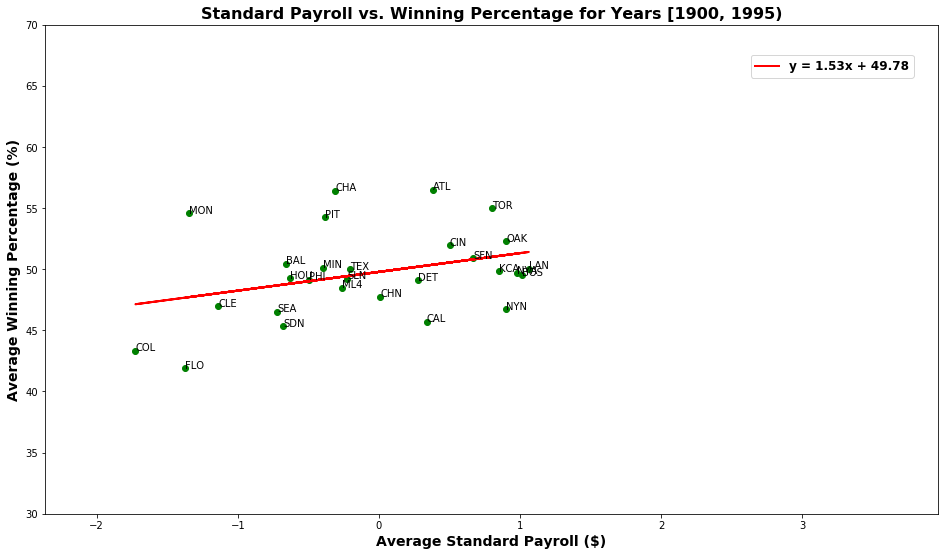

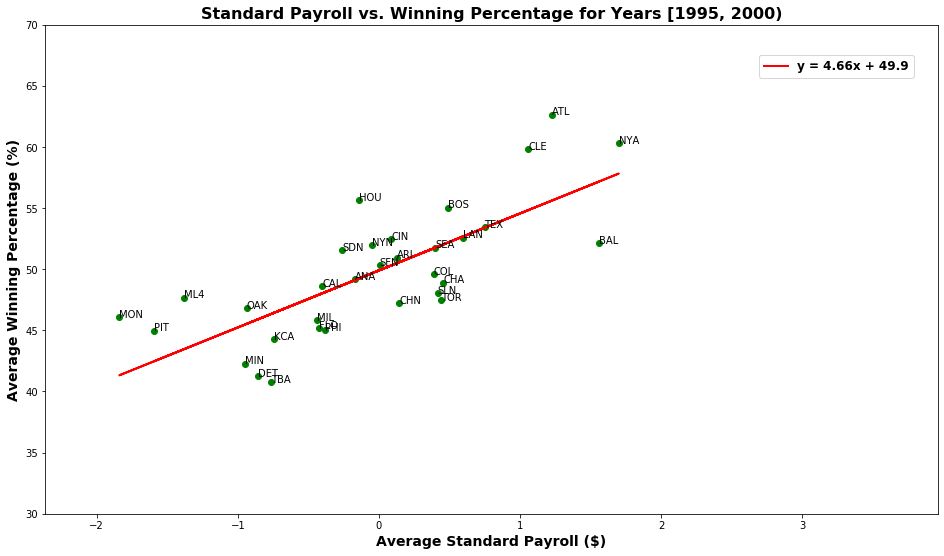

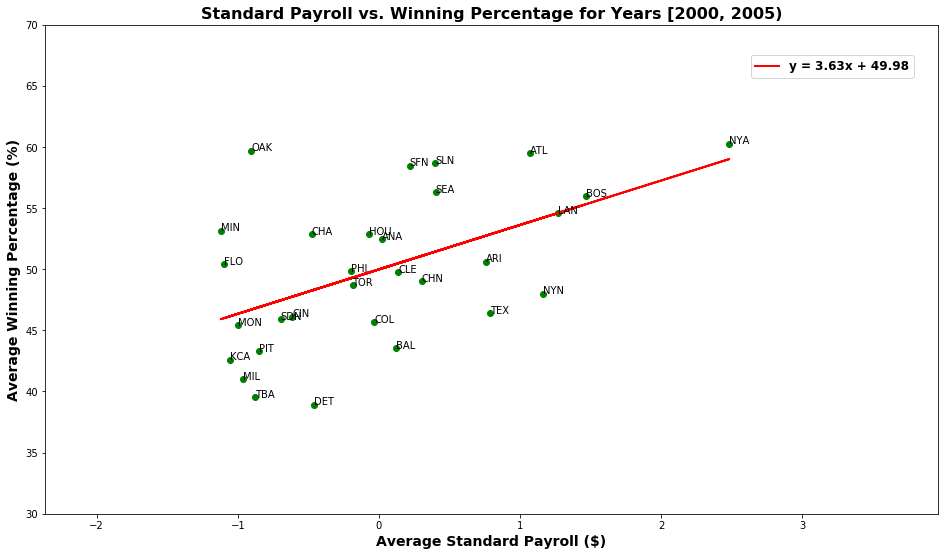

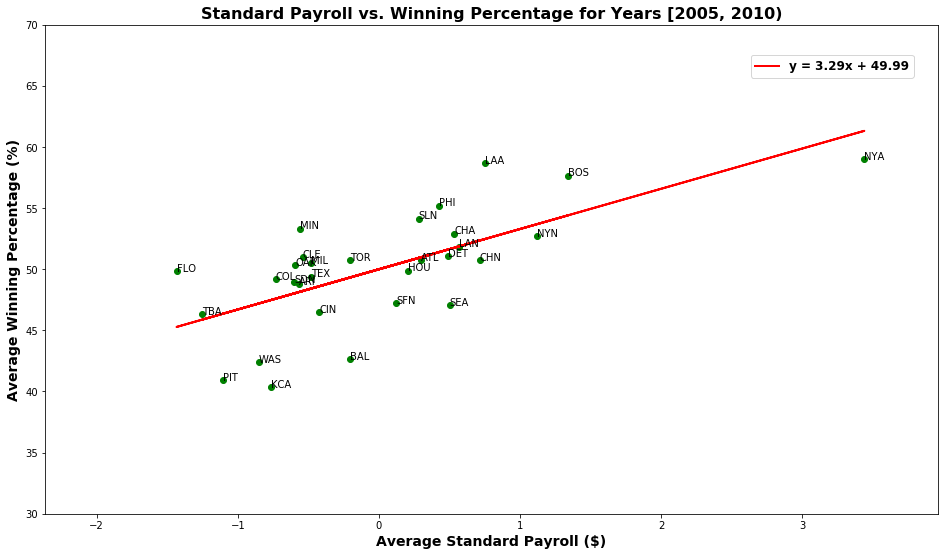

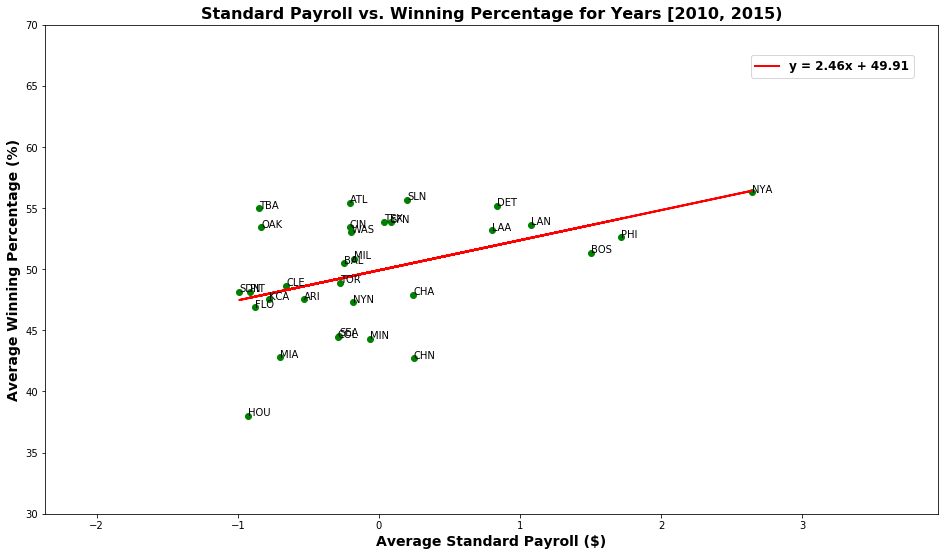

In [13]:
# Discretize year into five time periods
bins = [1900, 1995, 2000, 2005, 2010, 2015]
df['binned'] = pd.cut(df['yearID'], bins, right=False)
xMin = df['standardPayroll'].min()
xMax = df['standardPayroll'].max()

# Create scatterplot showing average payroll (x-axis) vs. mean winning percentage (y-axis) 
# For each of the five time periods, show relation for each team's averages
for b, bin in df.groupby('binned'):
    avg_p = []
    avg_w = []
    teams = []
    for t, team in bin.groupby('teamID'):
        avg_p.append(team['standardPayroll'].mean())
        avg_w.append(team['winningPercentage'].mean())
        teams.append(t)
        
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [16,9]
    ax.scatter(avg_p, avg_w, c='green')
    plt.ylim(30,70)
    plt.xlim(xMin,xMax)
    title = "Standard Payroll vs. Winning Percentage for Years " + str(b)
    plt.title(title, size=16, weight='bold')
    plt.xlabel("Average Standard Payroll ($)", size=14, weight='bold')
    plt.ylabel("Average Winning Percentage (%)", size=14, weight='bold')     
    for i, txt in enumerate(teams):
        ax.annotate(txt, (avg_p[i], avg_w[i]))
            
    # Plot with polyfit for interpretation
    b, m = polyfit(avg_p, avg_w, 1)    
    reg_line_str = "y = "+str(round(m, 2))+"x + "+str(round(b, 2))
    plt.plot(avg_p, np.multiply(m, avg_p) + b, '-', c='red', lw=2, label=reg_line_str)
    plt.legend(bbox_to_anchor=(.98,.95), loc=1, prop={'size': 12, 'weight':'bold'})
    
    plt.show()

### Question 3

<i><b>Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.</b></i>

<p>Standardization means transforming the data so that it has a mean of 0 and standard deviation of 1. Therefore, by calculating standard payroll, we re-scaled the data in a standardized way, such that the distribution comes roughly a normal distribution.</p>

<p>We can see in Problem 4, that the data points in earlier time periods are very compressed based on the smaller spread in total payroll, whereas data points in later time periods become horizontally wider from a larger spread.</p>

<p>After standardizing the payroll and displaying the results, we can see more a <b>more normalized distribution</b> of data points between standard payroll and winning percentage (the points are less compressed and easier to understand).</p>

### Problem 7

<p>Now that we have standardized payroll across time, we can look at a single plot showing correlation between winning percentage and payroll across time. The code below shows a single scatter plot of winning percentages (y-axis) vs. standardized payrolls (x-axis) for all teams. We also add a regression line to highlight the relationship.</p>

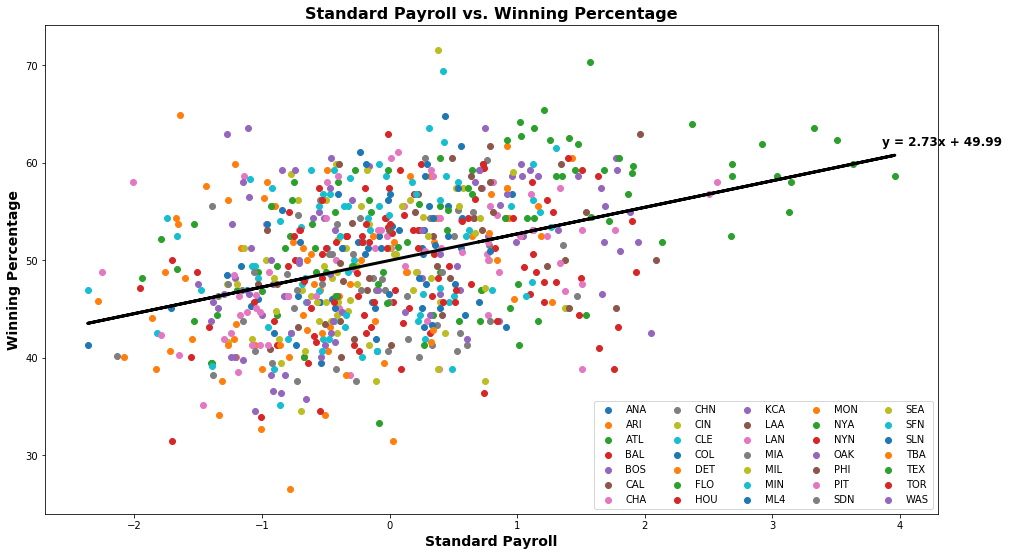

In [14]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [16,9]
for t, team in df.groupby('teamID'):
    ax.scatter(team['standardPayroll'], team['winningPercentage'], label=t)

plt.legend(ncol=5)
title = "Standard Payroll vs. Winning Percentage"
plt.title(title, size=16, weight='bold')
plt.xlabel("Standard Payroll", size=14, weight='bold')
plt.ylabel("Winning Percentage", size=14, weight='bold')     

# Plot with polyfit for interpretation
b, m = polyfit(df['standardPayroll'], df['winningPercentage'], 1)
reg_line_x = df['standardPayroll']
reg_line_y = np.multiply(m, df['standardPayroll']) + b
plt.plot(reg_line_x, reg_line_y, '-', c='black', lw=3)
last_reg_line_x = df['standardPayroll'].max()
last_reg_line_y = np.multiply(m, last_reg_line_x) + b

formula = "expected_win_pct = "+str(m)+" * standardized_payroll + "+str(b)
reg_line_str = "y = "+str(round(m, 2))+"x + "+str(round(b, 2))

ax.text(last_reg_line_x - 0.1, last_reg_line_y + 1, reg_line_str, size=12, weight='bold')

plt.show()

Using polyfit, we are able to find the slope (m = 2.73) and y-intercept (b = 49.99) for our equation, to express expected winning percentage as a function of standardized payroll. We can round our slope to 2.7, and y-intercept to 50 to express our formula as:

In [15]:
%%latex
$$expected\_win\_pct_{ij} = 2.7 * standardized\_payroll_{ij} + 50$$

<IPython.core.display.Latex object>

### Problem 8

<p>We can now create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.</p>

<p>Let's create a new field to compute each team's spending effiency, given by:</p>

In [16]:
%%latex
$$efficiency_{ij} = win\_pct_ij - expected\_win\_pct_{ij}$$

<IPython.core.display.Latex object>

In [17]:
for j, year in df.groupby('yearID'):    
    for i, team in year.groupby('teamID'):
        expected_win_pct = m*team['standardPayroll'] + b
        eff = team['winningPercentage'] - expected_win_pct 
        df.loc[(df['yearID']==j) & (df['teamID']==i),'efficiency'] = eff
        
df.head() # view first 5 records of df showing new efficiency column

,yearID,teamID,franchID,W,G,winningPercentage,totalPayroll,binned,standardPayroll,efficiency
0,1990,ATL,ATL,65,162,40.123457,14555501.0,"[1900, 1995)",-0.667275,-8.046701
1,1990,BAL,BAL,76,161,47.204969,9680084.0,"[1900, 1995)",-1.959861,2.557239
2,1990,BOS,BOS,88,162,54.320988,20558333.0,"[1900, 1995)",0.924213,1.813857
3,1990,CAL,ANA,80,162,49.382716,21720000.0,"[1900, 1995)",1.232198,-3.963704
4,1990,CHA,CHW,94,162,58.024691,9491500.0,"[1900, 1995)",-2.009859,13.513211


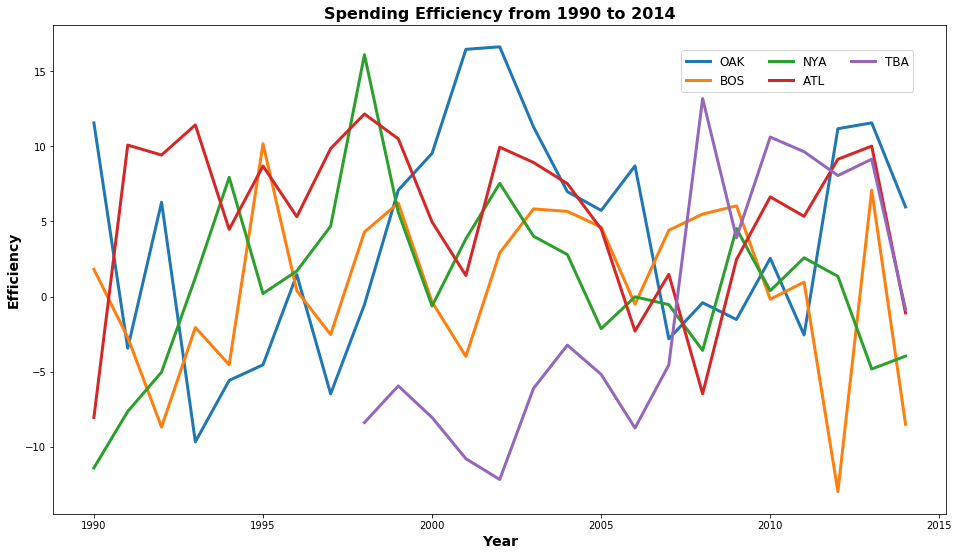

In [18]:
efficiency = df.pivot(index='yearID', columns='teamID', values='efficiency')
plt.rcParams["figure.figsize"] = [16,9]

# A good set of teams to plot: Oakland, New York Yankees, Boston, Atlanta and Tampa Bay 
# plot teamIDs: OAK, BOS, NYA, ATL, TBA
teams=['OAK','BOS','NYA','ATL','TBA']
for col in teams:
    plt.plot(efficiency[col], label=col, lw=3)
    plt.legend(col)

plt.title("Spending Efficiency from 1990 to 2014", size=16, weight='bold')
plt.xlabel("Year", size=14, weight='bold')
plt.ylabel("Efficiency", size=14, weight='bold')
plt.legend(bbox_to_anchor=(0.97,0.96), loc=1, ncol=3, prop={'size':'12'})
plt.show()

### Question 4

<i><b>
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3?<br> 
How good was Oakland's efficiency during the Moneyball period?
</b></i>

<p>Compared to the set of plots from Question 2 and Question 3, which showed the relation between payroll and winning percentage, this new data plot shows the <b><u>spending efficiency</u></b> of the following MLB teams: Oakland, New York Yankees, Boston, Atlanta and Tampa Bay.</p> 
<p>From this plot, we learn that teams do not have to spend so much in order to win. Payroll can be a factor in a team's performance, but in the case of Oakland, salaries are not what caused better results in the team's performance.</p>
<p>As shown in the plot above, compared to the other teams plotted, <b>Oakland had the highest spending efficiency during the Moneyball period</b> (between years 2000 and 2005).</p>

In [19]:
# View OAK's top 2 most efficient years
df.loc[df['teamID']=='OAK'].sort_values('efficiency', ascending=False).head(2)

,yearID,teamID,franchID,W,G,winningPercentage,totalPayroll,binned,standardPayroll,efficiency
358,2002,OAK,OAK,103,162,63.580247,40004167.0,"[2000, 2005)",-1.112298,16.622822
328,2001,OAK,OAK,102,162,62.962963,33810750.0,"[2000, 2005)",-1.276715,16.453590


In [20]:
# View NYA's most efficient year historically
df.loc[df['teamID']=='NYA'].sort_values('efficiency', ascending=False).head(1)

,yearID,teamID,franchID,W,G,winningPercentage,totalPayroll,binned,standardPayroll,efficiency
236,1998,NYA,NYY,114,162,70.37037,66806867.0,"[1995, 2000)",1.573223,16.094623


<p>If we look at OAK's records in our dataframe, we can see that their highest spending efficiency was in 2002 at a rate of 16.62, closely followed by their efficiency in 2001 at a rate of 16.45. Both of these spending efficiencies are greater than NYA's most efficient year, which was in 1998 at a rate of 16.09.</p>